In [52]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pywt
import os
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

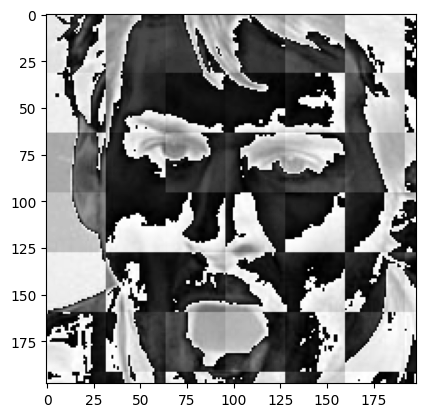

In [4]:
def w2d(img, mode='haar', level=1):
    imgArray = img
    imgArray = cv2.cvtColor(imgArray, cv2.COLOR_RGB2GRAY)
    imgArray = np.float32(imgArray)/255
    coeffs = pywt.wavedec2(imgArray, mode, level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    imgArray_H = pywt.waverec2(coeffs_H, mode)
    imgArray_H *= 255
    imgArray_H = np.uint8(imgArray_H)
    return imgArray_H

path = 'images_dataset\cropped\lionel_messi\lionel_messi3.png'
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_har = w2d(img, 'db1', 5)
plt.imshow(img_har, cmap='gray')

In [7]:
class_dict = {}
count = 0
for i in os.listdir('images_dataset\cropped'):
    class_dict[i] = count
    count += 1
count

5

In [17]:
X, y = [], []
for i in os.listdir('images_dataset\cropped'):
    for j in os.listdir('images_dataset\cropped\\'+i):
        path = 'images_dataset\cropped\\'+i+'\\'+j
        img = cv2.imread(path)
        scaled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img, 'db1', 5)
        scaled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3, 1), scaled_img_har.reshape(32*32, 1)))
        X.append(combined_img)
        y.append(class_dict[i])
    

In [18]:
32*32 * 3 + 32*32

4096

In [19]:
len(X[0])

4096

In [20]:
X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape

(170, 4096)

In [21]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.1, stratify=y)

pipe=Pipeline([
    ('scaler', StandardScaler()), 
    ('svc', SVC(kernel='rbf', C=10))
])

In [70]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=10))])

In [71]:
print(pipe.score(X_test, y_test))
print(classification_report(y_test, pipe.predict(X_test)))

0.9411764705882353
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      0.67      0.80         3
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00         4

    accuracy                           0.94        17
   macro avg       0.95      0.93      0.93        17
weighted avg       0.96      0.94      0.94        17



In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [73]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto', probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [74]:
scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.816559,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.693978,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.843441,{'logisticregression__C': 1}


In [75]:
best_estimators['svm'].score(X_test, y_test), best_estimators['random_forest'].score(X_test, y_test), best_estimators['logistic_regression'].score(X_test, y_test)

(0.9411764705882353, 0.6470588235294118, 0.9411764705882353)

In [76]:
best_clf = best_estimators['svm']

In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


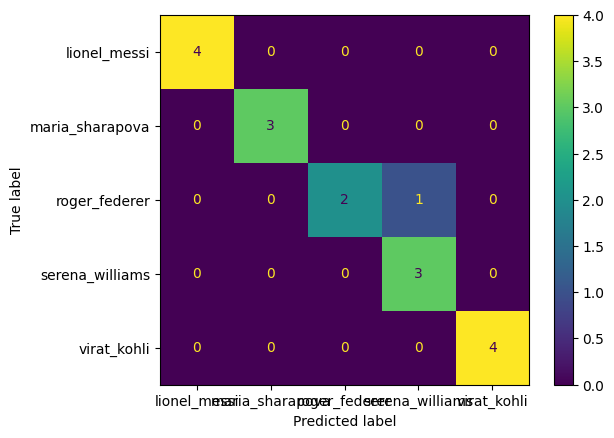

In [78]:
cm = confusion_matrix(y_test, best_clf.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_dict.keys())
disp.plot()

In [83]:
import joblib
import json

joblib.dump(best_clf, 'saved_model.pkl')
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))